##### 아래 블로그 주소를 참조할 것
https://cpm0722.github.io/pytorch-implementation/transformer

### 구조적 특징
이전 Seq2Seq모델은 입력 sentence의 Token을 순서대로 입력받아 한 번에 하나씩의 Hidden State를 생성했지만, transformer의 Encoder는 **입력 Sentence의 Token을 한꺼번에 입력받아 그 개수만큼의 Context Vector를 반환**한다

In [28]:
import torch.nn as nn
import torch
import copy
import math
import torch.functional as F
import numpy as np

## Encoder 전체 구조
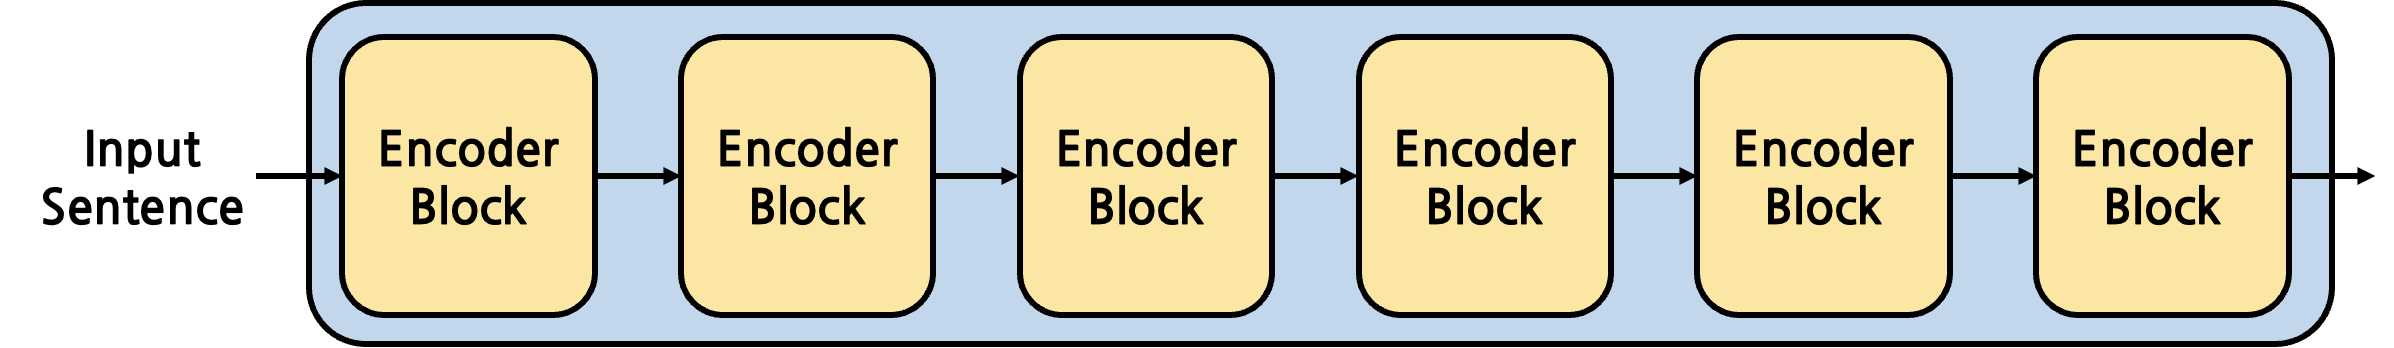

#### Encoder Block 구조
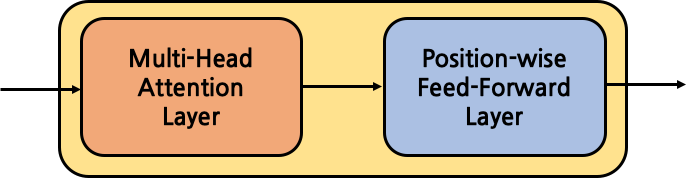

### Multi-Head Attention Layer 구조

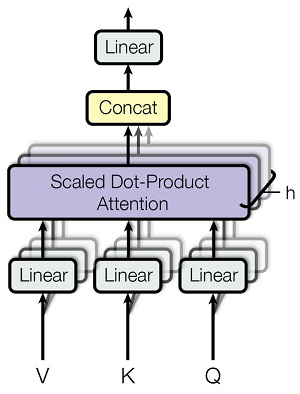

### Key, Query, Value의 계산

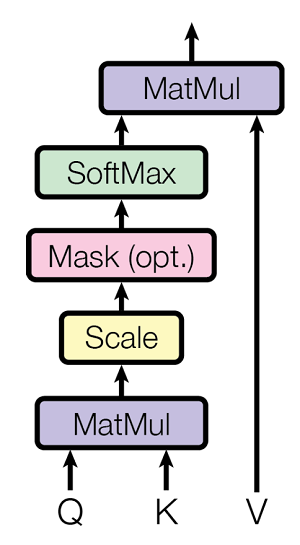

In [40]:
# Encoder의 MultiHeadAttentionLayer이다
# (n_batch, seq_len, d_embed)를 입력받아 똑같은 크기인 (n_batch, seq_len, d_embed)를 반환한다
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, d_model, h, qkv_fc, out_fc):
        super(MultiHeadAttentionLayer, self).__init__()
        self.d_model = d_model
        self.h = h
        self.q_fc = copy.deepcopy(qkv_fc) # (d_embed, d_model), d_model = d_k * h (논문에서 h=8이다)
        self.k_fc = copy.deepcopy(qkv_fc) # (d_embed, d_model), d_model = d_k * h (논문에서 h=8이다)
        self.v_fc = copy.deepcopy(qkv_fc) # (d_embed, d_model), d_model = d_k * h (논문에서 h=8이다)
        self.out_fc = out_fc              # (d_model, d_embed)


    def forward(self, *args, query, key, value, mask=None):
        # query, key, value: (n_batch, seq_len, d_embed), Q,K,V를 만드는 FC Layer에 입력되기 이전의 Q,K,V이다
        # mask: (n_batch, seq_len, seq_len) pad_masking용
        # return value: (n_batch, h, seq_len, d_k)
        n_batch = query.size(0)

        # 입력값 x를 fc에 통과시키고 적절하게 형태를 바꾼 후 출력하는 함수이다
        # 즉 Q,K,V를 구할 때 사용하는 함수이다
        def transform(x, fc):  # (n_batch, seq_len, d_embed)
            out = fc(x)        # (n_batch, seq_len, d_model)
            out = out.view(n_batch, -1, self.h, self.d_model//self.h) # (n_batch, seq_len, h, d_k)
            out = out.transpose(1, 2) # (n_batch, h, seq_len, d_k)
            return out

        query = transform(query, self.q_fc) # (n_batch, h, seq_len, d_k)
        key = transform(key, self.k_fc)     # (n_batch, h, seq_len, d_k)
        value = transform(value, self.v_fc) # (n_batch, h, seq_len, d_k)

        # Qeury의 Attention value들을 계산한다
        out = self.calculate_attention(query, key, value, mask) # (n_batch, h, seq_len, d_k)
        out = out.transpose(1, 2) # (n_batch, seq_len, h, d_k)

        # contiguous() : 이리저리 뒤바뀐 각 원소의 메모리 주소를 axis방향으로 나열되도록 정렬하는 메모리 메소드이다
        out = out.contiguous().view(n_batch, -1, self.d_model) # (n_batch, seq_len, d_model)
        out = self.out_fc(out) # (n_batch, seq_len, d_embed)
        return out

    # Query, Key, Value, Mask를 입력받아 Attention Value를 출력하는 함수
    def calculate_attention(self, query, key, value, mask):
        # query, key, value: (n_batch, h, seq_len, d_k)
        # mask: (n_batch, 1, seq_len, seq_len)
        d_k = key.shape[-1]
        attention_score = torch.matmul(query, key.transpose(-2, -1)) # Q x K^T, (n_batch, h, seq_len, seq_len)
        attention_score = attention_score / math.sqrt(d_k)
        if mask is not None:
            attention_score = attention_score.masked_fill(mask==0, -1e9)
        attention_prob = F.softmax(attention_score, dim=-1) # (n_batch, h, seq_len, seq_len)
        out = torch.matmul(attention_prob, value) # (n_batch, h, seq_len, d_k)
        return out

In [44]:
# Encoder의 MultiHeadAttentionLayer이다
# (n_batch, seq_len, d_embed)를 입력받아 똑같은 크기인 (n_batch, seq_len, d_embed)를 반환한다
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, d_model, h, qkv_fc, out_fc):
        super(MultiHeadAttentionLayer, self).__init__()
        self.d_model = d_model
        self.h = h
        self.q_fc = copy.deepcopy(qkv_fc) # (d_embed, d_model), d_model = d_k * h (논문에서 h=8이다)
        self.k_fc = copy.deepcopy(qkv_fc) # (d_embed, d_model), d_model = d_k * h (논문에서 h=8이다)
        self.v_fc = copy.deepcopy(qkv_fc) # (d_embed, d_model), d_model = d_k * h (논문에서 h=8이다)
        self.out_fc = out_fc              # (d_model, d_embed)


    def forward(self, *args, query, key, value, mask=None):
        # query, key, value: (n_batch, seq_len, d_embed), Q,K,V를 만드는 FC Layer에 입력되기 이전의 Q,K,V이다
        # mask: (n_batch, seq_len, seq_len) pad_masking용
        # return value: (n_batch, h, seq_len, d_k)
        n_batch = query.size(0)

        # 입력값 x를 fc에 통과시키고 적절하게 형태를 바꾼 후 출력하는 함수이다
        # 즉 Q,K,V를 구할 때 사용하는 함수이다
        def transform(x, fc):  # (n_batch, seq_len, d_embed)
            out = fc(x)        # (n_batch, seq_len, d_model)
            out = out.view(n_batch, -1, self.h, self.d_model//self.h) # (n_batch, seq_len, h, d_k)
            out = out.transpose(1, 2) # (n_batch, h, seq_len, d_k)
            return out

        query = transform(query, self.q_fc) # (n_batch, h, seq_len, d_k)
        key = transform(key, self.k_fc)     # (n_batch, h, seq_len, d_k)
        value = transform(value, self.v_fc) # (n_batch, h, seq_len, d_k)

        # Qeury의 Attention value들을 계산한다
        out = self.calculate_attention(query, key, value, mask) # (n_batch, h, seq_len, d_k)
        out = out.transpose(1, 2) # (n_batch, seq_len, h, d_k)

        # contiguous() : 이리저리 뒤바뀐 각 원소의 메모리 주소를 axis방향으로 나열되도록 정렬하는 메모리 메소드이다
        out = out.contiguous().view(n_batch, -1, self.d_model) # (n_batch, seq_len, d_model)
        out = self.out_fc(out) # (n_batch, seq_len, d_embed)
        return out

    # Query, Key, Value, Mask를 입력받아 Attention Value를 출력하는 함수
    def calculate_attention(self, query, key, value, mask):
        # query, key, value: (n_batch, h, seq_len, d_k)
        # mask: (n_batch, 1, seq_len, seq_len)
        d_k = key.shape[-1]
        attention_score = torch.matmul(query, key.transpose(-2, -1)) # Q x K^T, (n_batch, h, seq_len, seq_len)
        attention_score = attention_score / math.sqrt(d_k)
        if mask is not None:
            attention_score = attention_score.masked_fill(mask==0, -1e9)
        attention_prob = F.softmax(attention_score, dim=-1) # (n_batch, h, seq_len, seq_len)
        out = torch.matmul(attention_prob, value) # (n_batch, h, seq_len, d_k)
        return out

# Encoder 끝부분에 존재하는 두 개의 FC Layer이다
# (n_batch, seq_len, d_model)크기의 Multi-Head Attention Layer의 출력값이 이걸 통과하여 
# (n_batch, seq_len, d_model)크기가 유지되며 다음 Encoder로 넘어감
class PositionWiseFeedForwardLayer(nn.Module):

    def __init__(self, fc1, fc2):
        super(PositionWiseFeedForwardLayer, self).__init__()
        self.fc1 = fc1   # (d_embed, d_ff)
        self.relu = nn.ReLU()
        self.fc2 = fc2 # (d_ff, d_embed)

    def forward(self, x):
        out = x
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# 각각 Encoder의 Skip-Connection구현
class ResidualConnectionLayer(nn.Module):
    def __init__(self):
        super(ResidualConnectionLayer, self).__init__()

    def forward(self, x, sub_layer):
        out = x
        out = sub_layer(out)
        out = out + x
        return out

# 하나의 Encoder Block
class EncoderBlock(nn.Module):

    def __init__(self, self_attention, position_ff):
        super(EncoderBlock, self).__init__()
        self.self_attention = self_attention
        self.position_ff = position_ff
        self.residuals = [ResidualConnectionLayer() for _ in range(2)]

    # mask : pad_masking에 사용할 mask이다
    # 문장 토큰 개수를 seq_len으로 맞추기 위하여 삽입되었던 padding Token의 attention value를 0으로 만들어주기 위함이다
    def forward(self, src, src_mask):
        out = src
        out = self.residuals[0](out, lambda out: self.self_attention(query=out, key=out, value=out, mask=src_mask))
        out = self.residuals[1](out, self.position_ff)
        return out

# 전체 Encoder
class Encoder(nn.Module):

    def __init__(self, encoder_layer, n_layer):  # n_layer: Encoder Layer의 개수. 논문에서는 6개
        super(Encoder, self).__init__()
        self.layers = []
        for i in range(n_layer):
            self.layers.append(copy.deepcopy(encoder_layer))

             
    def forward(self, src, src_mask):
        out = src
        for layer in self.layers:
            out = layer(out, src_mask)
        return out

## 전체 Decoder 구조
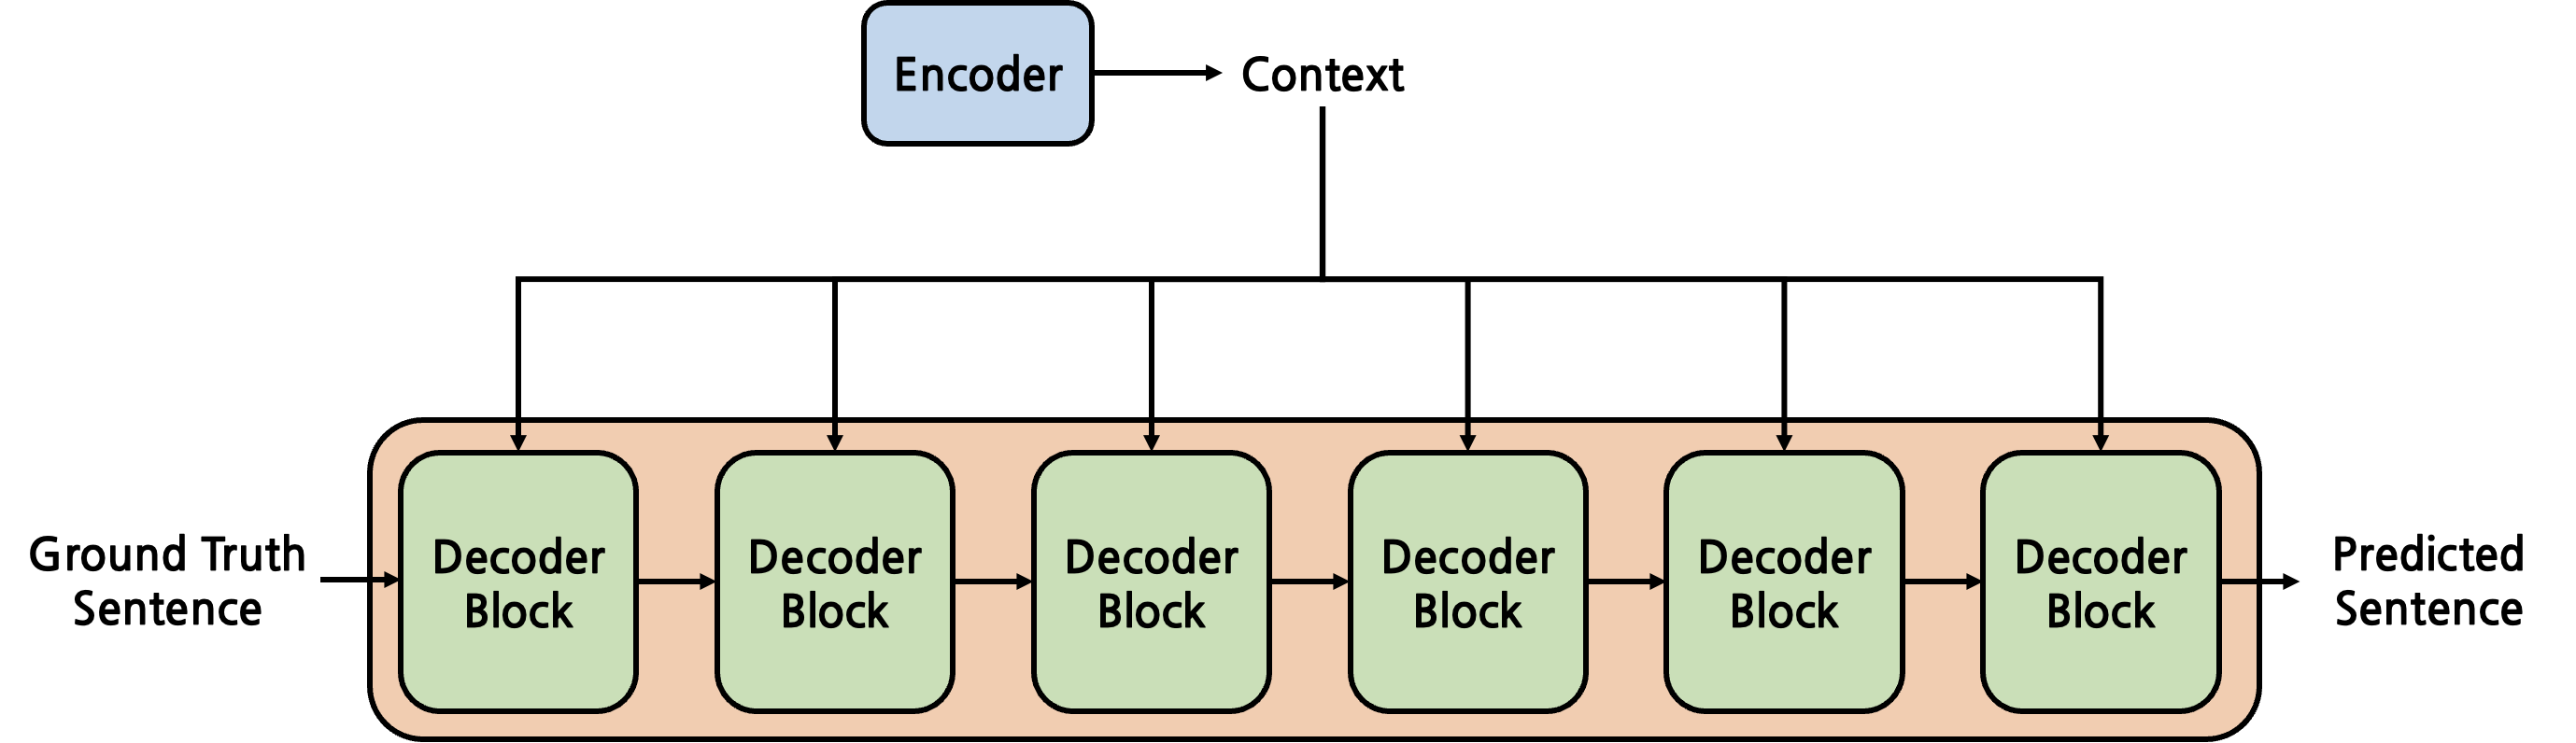

## Deocder Block 구조

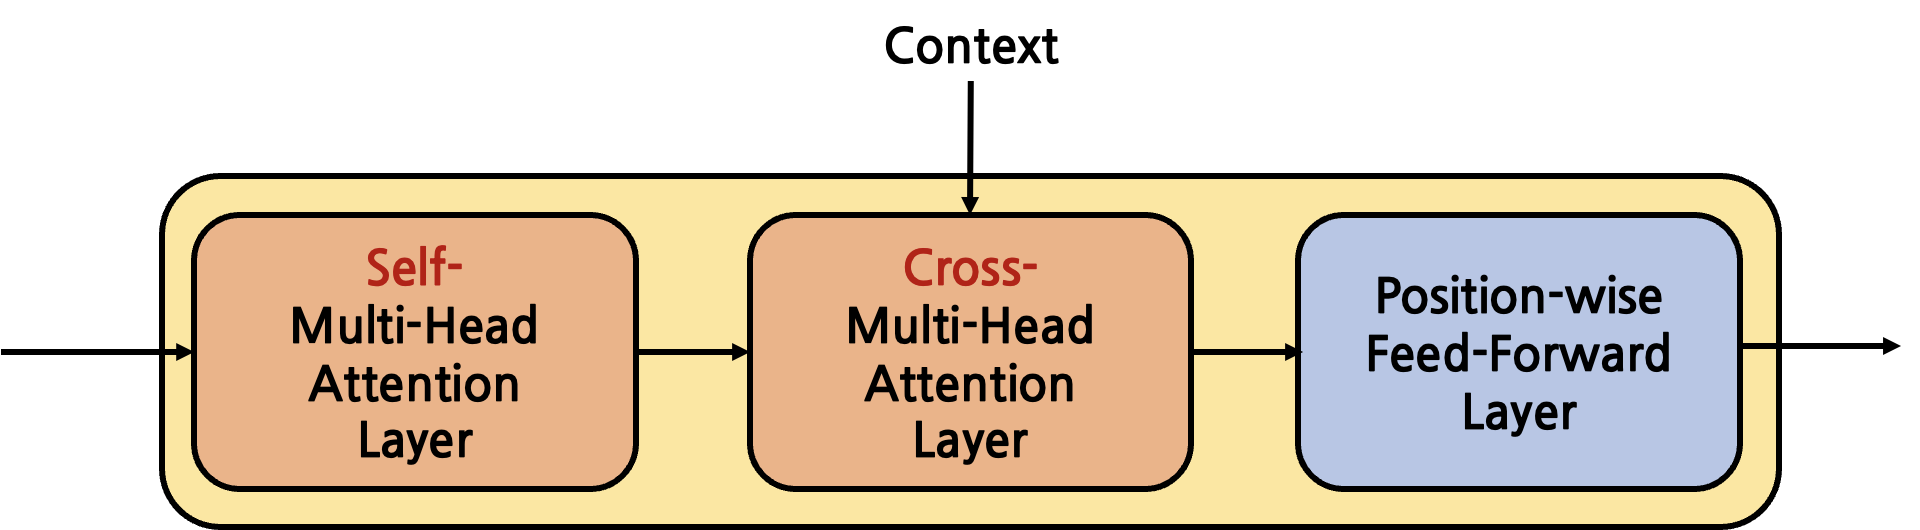

In [35]:
# 하나의 Decoder Block
class DecoderBlock(nn.Module):

    def __init__(self, self_attention, cross_attention, position_ff):
        super(DecoderBlock, self).__init__()
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.position_ff = position_ff
        self.residuals = [ResidualConnectionLayer() for _ in range(3)]

    # cross_attention의 key, value는 encoder_out이라는 것, 
    # 각각 mask가 tgt_mask, src_tgt_mask라는 것만 주의
    def forward(self, tgt, encoder_out, tgt_mask, src_tgt_mask):
        out = tgt
        out = self.residuals[0](out, lambda out: self.self_attention(query=out, key=out, value=out, mask=tgt_mask))
        out = self.residuals[1](out, lambda out: self.cross_attention(query=out, key=encoder_out, value=encoder_out, mask=src_tgt_mask))
        out = self.residuals[2](out, self.position_ff)
        return out

# 전체 Decoder
class Decoder(nn.Module):

    def __init__(self, decoder_block, n_layer):
        super(Decoder, self).__init__()
        self.n_layer = n_layer # 논문에서는 6개로 지정
        self.layers = nn.ModuleList([copy.deepcopy(decoder_block) for _ in range(self.n_layer)])

    # encoder_out : Encoder에서 생성된 최종 output은 
    # 모든 Decoder Block 내부의 Cross-Multi-Head Attention Layer에 Key, Value로써 주어진다

    # tgt_mask : Decoder의 input으로 주어지는 target sentence의 pad masking과 subsequent masking
    # src_tgt_mask : Self-Multi-Head Attention Layer에서 넘어온 query, Encoder에서 넘어온 key, value 사이의 pad masking
    def forward(self, tgt, encoder_out, tgt_mask, src_tgt_mask):
        out = tgt
        for layer in self.layers:
            out = layer(out, encoder_out, tgt_mask, src_tgt_mask)
        return out

#### Positional Encoding
* transformer는 RNN, LSTM과 달리 입력 Token을 순차적으로 받는 것이 아니라, **한꺼번에 입력**받기 때문에 이들 단어간 "순서"를 나타내는 정보가 없어지게 된다.

* 그럼에도 **어순은 언어를 이해하는 데 중요한 역할**을 하기에 이 정보에 대한 처리가 필요

* attention layer에 들어가기 전에 입력값으로 주어질 단어 vector 안에 positional encoding 정보, 즉, **단어의 위치 정보를 포함시키고자 하는 것**

In [45]:
# Transformer의 input으로 들어오는 문장의 shape는 (n_batch×seq_len)
# 하지만 Encoder와 Decoder로 들어오는 입력값의 shape는 (n_batch×seq_len×dembed)이다
# 즉, 입력값이 들어오기 전에 Embedding Vector화 되는 것이다

# Transformer의 Embedding은 단순하게 Token Embedding과 Positional Encoding의 sequential로 구성
class TransformerEmbedding(nn.Module):

    def __init__(self, token_embed, pos_embed):
        super(TransformerEmbedding, self).__init__()
        self.embedding = nn.Sequential(token_embed, pos_embed)


    def forward(self, x):
        out = self.embedding(x)
        return out

# Token Embedding
class TokenEmbedding(nn.Module):

    def __init__(self, d_embed, vocab_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_embed)
        self.d_embed = d_embed


    def forward(self, x):
        out = self.embedding(x) * math.sqrt(self.d_embed) # scaling을 적용하여 출력한다
        return out

# positional embedding : code가 난해하여 작동 원리만 이해하고 넘어가자
# PositionalEncoding의 목적은 positional 정보(token index number 등)를 정규화시키기 위한 것이다
# 
class PositionalEncoding(nn.Module):

    def __init__(self, d_embed, max_len=256, device=torch.device("cpu")):
        super(PositionalEncoding, self).__init__()
        encoding = torch.zeros(max_len, d_embed)
        encoding.requires_grad = False # encoding이 학습되지 않도록 requires_grad=False 을 부여
        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_embed, 2) * -(math.log(10000.0) / d_embed))
        encoding[:, 0::2] = torch.sin(position * div_term)
        encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = encoding.unsqueeze(0).to(device)

    def forward(self, x):
        _, seq_len, _ = x.size()
        pos_embed = self.encoding[:, :seq_len, :]
        out = x + pos_embed
        return out

### 전체 Transformer

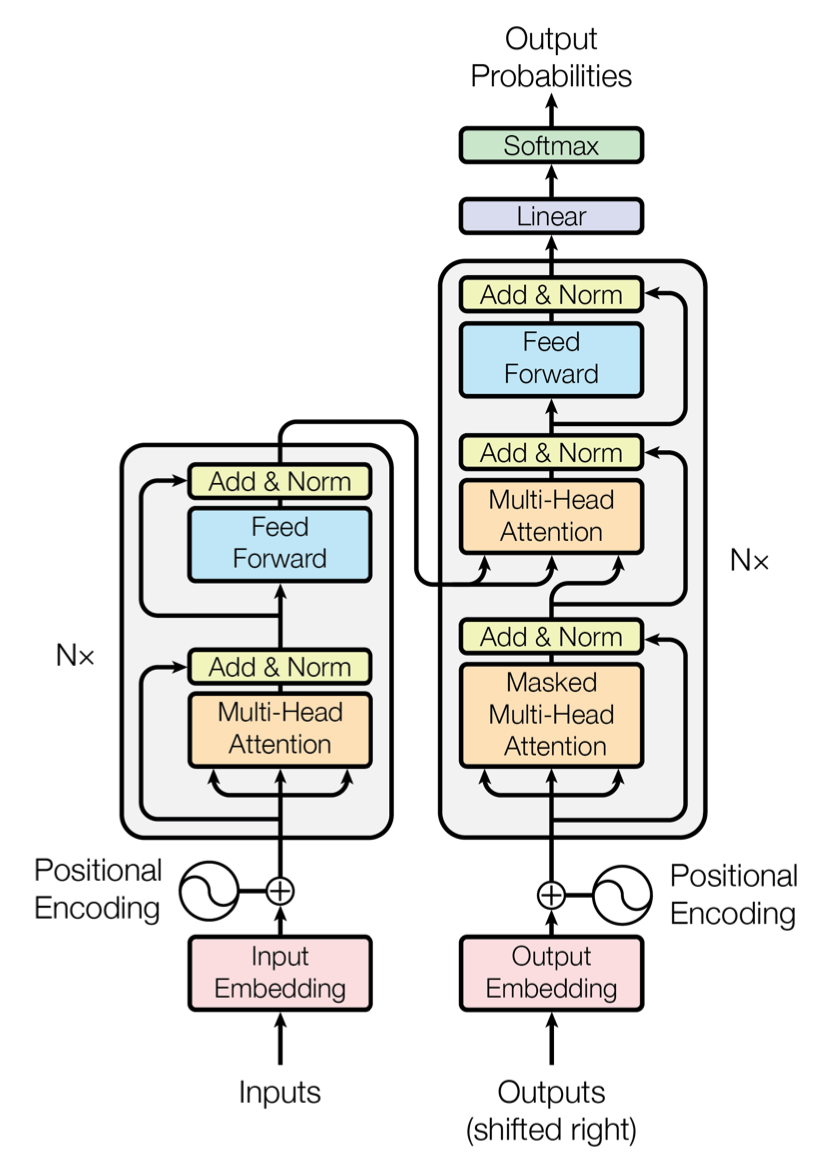

In [46]:
# 전체 Transformer구현하기
class Transformer(nn.Module):

    def __init__(self, src_embed, tgt_embed, encoder, decoder, generator):
        super(Transformer, self).__init__()
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.encoder = encoder # Encoder
        self.decoder = decoder # Decoder
        self.generator = generator # Decoder에서 출력된 (n_batch, seq_len, d_embed)를 우리가 원하는 (n_batch, seq_len)으로 변화시키는 역할을 한다


    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)


    def decode(self, tgt, encoder_out, tgt_mask, src_tgt_mask):
        return self.decoder(self.tgt_embed(tgt), encoder_out, tgt_mask, src_tgt_mask)

    def forward(self, src, tgt):
        src_mask = self.make_src_mask(src) # encoder에 사용 될 Padding Mask
        tgt_mask = self.make_tgt_mask(tgt) # Decoder의 self-MHAL에서 사용할 Padding Mask + Subsequent_Mask
        src_tgt_mask = self.make_src_tgt_mask(src, tgt) # Decoder의 cross-MHAL에서 사용할 Padding Mask
        encoder_out = self.encode(src, src_mask) # Encoder의 출력
        decoder_out = self.decode(tgt, encoder_out, tgt_mask, src_tgt_mask) # Decoder의 출력
        out = self.generator(decoder_out) # Decoder의 output이 Generator에 입력되어 우리가 원하는 형태로 출력된다
        out = F.log_softmax(out, dim=-1) # dim = -1 (마지막 차원 기준 softmax) : 마지막 dimension인 len(vocab)에 대한 확률값을 구해야 하기 때문
        return out, decoder_out        

    # 입력문장 token인 src를 받아 pad_masking용 마스크를 반환한다
    def make_src_mask(self, src):
        pad_mask = self.make_pad_mask(src, src)
        return pad_mask

    # encoder에 입력할 pad_making용 mask를 만드는 함수이다
    def make_pad_mask(self, query, key, pad_idx=1):
        # query: (n_batch, query_seq_len) 즉, embedding처리 이전의 sentence자체가 들어간다
        # key: (n_batch, key_seq_len) 즉, embedding처리 이전의 sentence자체가 들어간다
        query_seq_len, key_seq_len = query.size(1), key.size(1) # 문장의 길이

        # key.ne(1) : key로 입력된 각각의 값들이 0이라면 (즉, pad token이라면) 전부 값을 1로 바꾼다
        key_mask = key.ne(pad_idx).unsqueeze(1).unsqueeze(2)  # (n_batch, 1, 1, key_seq_len)

        # 그래서 다음과 같이 seq_len * seq_len 크기의 pad_mask가 만들어졌다
        key_mask = key_mask.repeat(1, 1, query_seq_len, 1)    # (n_batch, 1, query_seq_len, key_seq_len)

        query_mask = query.ne(pad_idx).unsqueeze(1).unsqueeze(3)  # (n_batch, 1, query_seq_len, 1)
        query_mask = query_mask.repeat(1, 1, 1, key_seq_len)  # (n_batch, 1, query_seq_len, key_seq_len)

        mask = key_mask & query_mask
        mask.requires_grad = False
        return mask        


        # Teacher Forcing을 위한 Subsequent Mask생성함수
        # 0번쨰 token은 자기 자신밖에 보지 못하고, 
        # 1~n번쨰 token은 0으로 가려져 있으며, 
        # 1번째 token은 0~1번째 token밖에 보지 못하고, 
        # 2~n번째 token은 모두 0으로 가려져 있다. 
        # 최종적으로 n번쨰 token은 모든 token을 볼 수 있다. 
        # 이렇듯, Decoder의 mask는 subsequent masking이 적용되어야 한다

        def make_subsequent_mask(query, key):
            # query: (n_batch, query_seq_len)
            # key: (n_batch, key_seq_len)
            query_seq_len, key_seq_len = query.size(1), key.size(1)

            tril = np.tril(np.ones((query_seq_len, key_seq_len)), k=0).astype('uint8') # 10 * 10의 Lower Trianglular Matrix를 생성한다
            mask = torch.tensor(tril, dtype=torch.bool, requires_grad=False, device=query.device)
            return mask

        # 그런데, 동시에 Encoder와 마찬가지로 pad masking역시 적용되어야 한다.
        def make_tgt_mask(self, tgt):
            pad_mask = self.make_pad_mask(tgt, tgt)
            seq_mask = self.make_subsequent_mask(tgt, tgt)
            mask = pad_mask & seq_mask
            return pad_mask & seq_mask

        # Self-Multi-Head Attention Layer에서 넘어온 query, Encoder에서 넘어온 key, value 사이의 pad masking을 구하는 메소드
        def make_src_tgt_mask(self, src, tgt):
            pad_mask = self.make_pad_mask(tgt, src)
            return pad_mask


In [39]:
# transformer를 생성하는 Factory Method를 정의한다
def build_model(src_vocab_size, tgt_vocab_size, device=torch.device("cpu"), max_len=256, d_embed=512, n_layer=6, d_model=512, h=8, d_ff=2048):
    import copy
    copy = copy.deepcopy

    src_token_embed = TokenEmbedding(
                                     d_embed = d_embed,
                                     vocab_size = src_vocab_size)
    tgt_token_embed = TokenEmbedding(
                                     d_embed = d_embed,
                                     vocab_size = tgt_vocab_size)
    pos_embed = PositionalEncoding(
                                   d_embed = d_embed,
                                   max_len = max_len,
                                   device = device)

    src_embed = TransformerEmbedding(
                                     token_embed = src_token_embed,
                                     pos_embed = copy(pos_embed))
    tgt_embed = TransformerEmbedding(
                                     token_embed = tgt_token_embed,
                                     pos_embed = copy(pos_embed))

    attention = MultiHeadAttentionLayer(
                                        d_model = d_model,
                                        h = h,
                                        qkv_fc = nn.Linear(d_embed, d_model),
                                        out_fc = nn.Linear(d_model, d_embed))
    position_ff = PositionWiseFeedForwardLayer(
                                               fc1 = nn.Linear(d_embed, d_ff),
                                               fc2 = nn.Linear(d_ff, d_embed))

    encoder_block = EncoderBlock(
                                 self_attention = copy(attention),
                                 position_ff = copy(position_ff))
    decoder_block = DecoderBlock(
                                 self_attention = copy(attention),
                                 cross_attention = copy(attention),
                                 position_ff = copy(position_ff))

    encoder = Encoder(
                      encoder_block = encoder_block,
                      n_layer = n_layer)
    decoder = Decoder(
                      decoder_block = decoder_block,
                      n_layer = n_layer)
    generator = nn.Linear(d_model, tgt_vocab_size)

    model = Transformer(
                        src_embed = src_embed,
                        tgt_embed = tgt_embed,
                        encoder = encoder,
                        decoder = decoder,
                        generator = generator).to(device)
    model.device = device

    return model